# XAI Laboratory 01 - Tabular Methods

For this practice, you will need the following dataset:

- **fifa**: regression dataset containing FIFA players data:
    - short_name: name of the player
    - nationality
    - overall: overall score of the player (potential output)
    - potential: potential score of the player (potential output)
    - wage_eur: contract cancellation fine of the player (potential output)
    - value_eur: value in euros of the player (potential output)
    - age: age of the player in years
    - height_cm: height of the player in cm
    - weight_kg: weight of the player in kg
    - attacking_skills: several variables related to attacking
    - defending_skills: several variables related to defending
    - goalkeeping_skills: several variables related to goalkeeping

Use what you have learned from the `tabular_explanation.ipynb` notebook to complete the questions.

In [1]:
# !pip install xgboost

In [2]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# XAI
import shap
import lime
from alepython import ale_plot # You might need to install from source: pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(2025)

c:\Users\User\Documents\Primero\etica_y_explicabilidad\Practicas\p1-tabular-methods-sofiapedros\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
### Load file --------------------------------------------
df = pd.read_csv('../data/fifa.csv')
df.head()

,short_name,nationality,overall,potential,wage_eur,value_eur,age,height_cm,weight_kg,attacking_crossing,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,Argentina,94,94,565000,95500000,32,170,72,88,...,75,96,33,37,26,6,11,15,14,8
1,Cristiano Ronaldo,Portugal,93,93,405000,58500000,34,187,83,84,...,85,95,28,32,24,7,11,15,14,11
2,Neymar Jr,Brazil,92,92,290000,105500000,27,175,68,87,...,90,94,27,26,29,9,9,15,15,11
3,J. Oblak,Slovenia,91,93,125000,77500000,26,188,87,13,...,11,68,27,12,18,87,92,78,90,89
4,E. Hazard,Belgium,91,91,470000,90000000,28,175,74,81,...,88,91,34,27,22,11,12,6,8,8


In [4]:
X = df.drop(["short_name", "nationality", "overall", "potential", "value_eur", "wage_eur"], axis = 1)
y = df['value_eur']

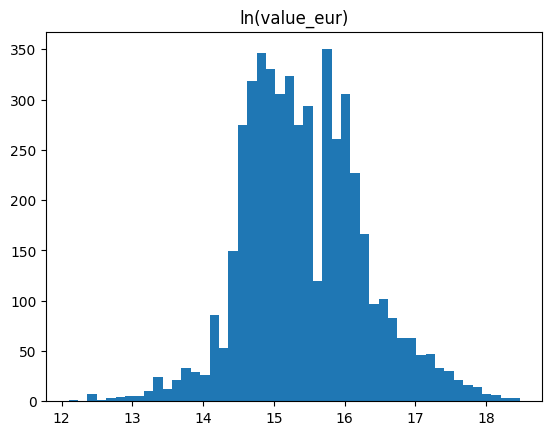

In [5]:
# Change scale of output variable
ylog = np.log(y)

plt.hist(ylog, bins='auto')
plt.title("ln(value_eur)")
plt.show()

In [6]:
X_train, X_test, ylog_train, ylog_test, y_train, y_test = train_test_split(X, ylog, y, test_size=0.25, random_state=42)

In [7]:
# Train XGBoost model, may take a few minutes
model = XGBRegressor()
model.fit(X_train, ylog_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [8]:
def predict_function(model, data):
    """Predict wrapper: original model was trained on log-output; return exp(pred) to recover original scale."""
    return np.exp(model.predict(data))

---
Ex 1. Ensure your model is not overfitted

Train RMSE: 317968.09
Test RMSE: 3097290.61


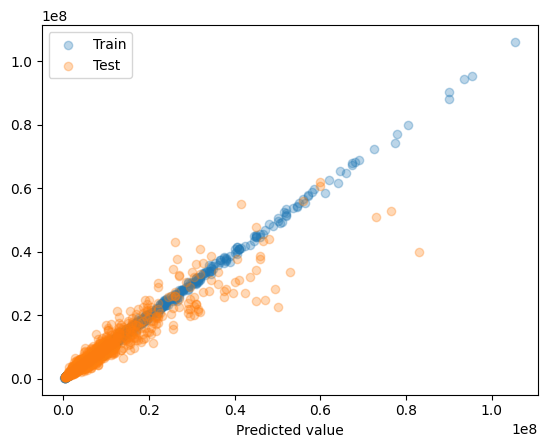

In [17]:
from sklearn.metrics import mean_squared_error

train_prediction = predict_function(model, X_train)
test_prediction = predict_function(model, X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_prediction))
test_rmse  = np.sqrt(mean_squared_error(y_test, test_prediction))

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

# He intentado ver la evolución de la pérdida, pero no 
plt.scatter(y_train, train_prediction, alpha=0.3, label="Train")
plt.scatter(y_test, test_prediction, alpha=0.3, label="Test")
plt.xlabel("Actual value")
plt.xlabel("Predicted value")
plt.legend()
plt.show()


> It looks like the model is not overfitting because the RMSE is similar in training and test. Additionally, the prediction done by the model in the test set appears to be correct, as they correspond to the real values (they mostly follow the diagonal in the plot)

---
Ex 2. Obtain and plot variable importance measures using the following variable groups

In [10]:
variable_groups = {
    'age': ['age'],
    'body': ['height_cm', 'weight_kg'],
    'attacking': ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys'],
    'skill': ['skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control'],
    'movement': ['movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance'],
    'power': ['power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots'],
    'mentality': ['mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties',
        'mentality_composure'],
    'defending': ['defending_marking', 'defending_standing_tackle','defending_sliding_tackle'],
    'goalkeeping' : ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
}

{'body': 0.0005887507421083348, 'power': 0.0070512581489190675, 'mentality': 0.009821203396598512, 'goalkeeping': 0.021451831602379495, 'defending': 0.026287320858616015, 'skill': 0.027362590566855843, 'attacking': 0.027831404991275448, 'movement': 0.029552998059890402, 'age': 0.35288569347952703}


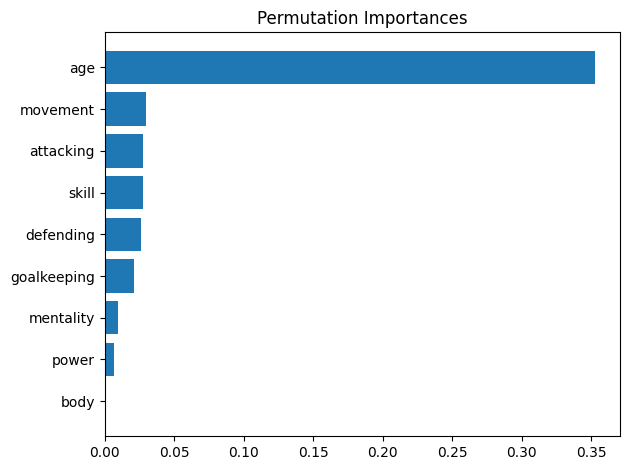

In [11]:
# Compute permutation importances
perm_imp = permutation_importance(model, X_test, ylog_test,
                           n_repeats=30,
                           random_state=0)


group_importance = {}
for group, cols in variable_groups.items():
    colum_indexes = [X.columns.get_loc(col) for col in cols if col in X.columns]
    group_importance[group] = np.mean([perm_imp.importances_mean[i] for i in colum_indexes])

group_importance = dict(sorted(group_importance.items(), key=lambda item: item[1]))
print(group_importance)


fig, ax = plt.subplots()

ax.barh(list(group_importance.keys()), group_importance.values())
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

---
Ex 3. Obtain which is the variable with higher influence in Leo Messi's value. Justify which algorithm you choose

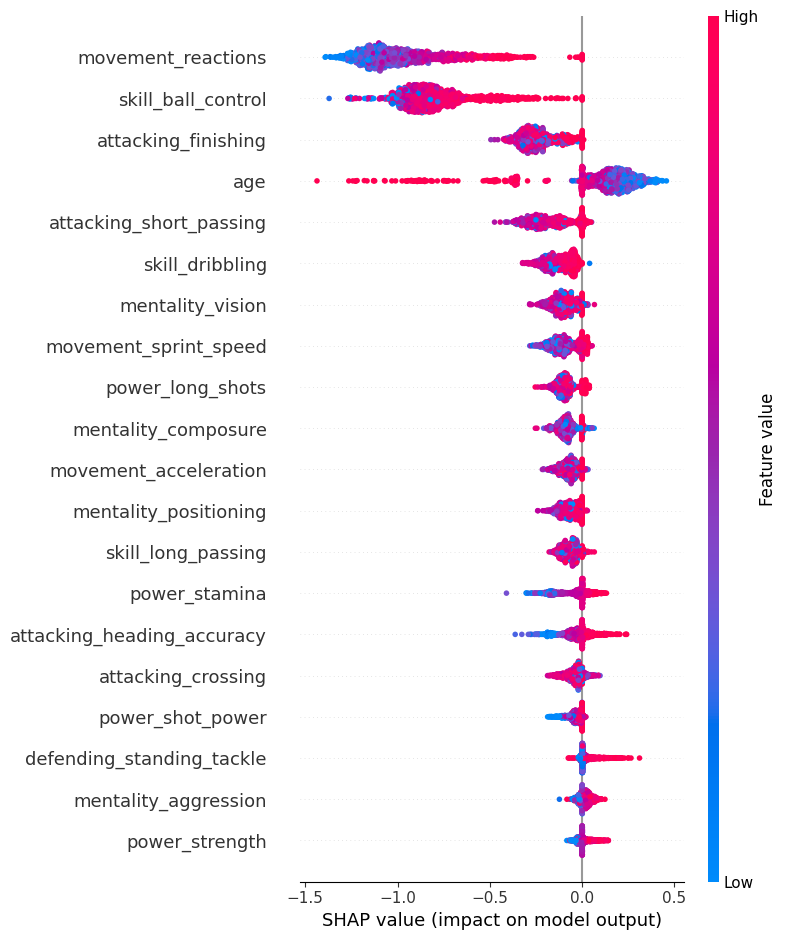

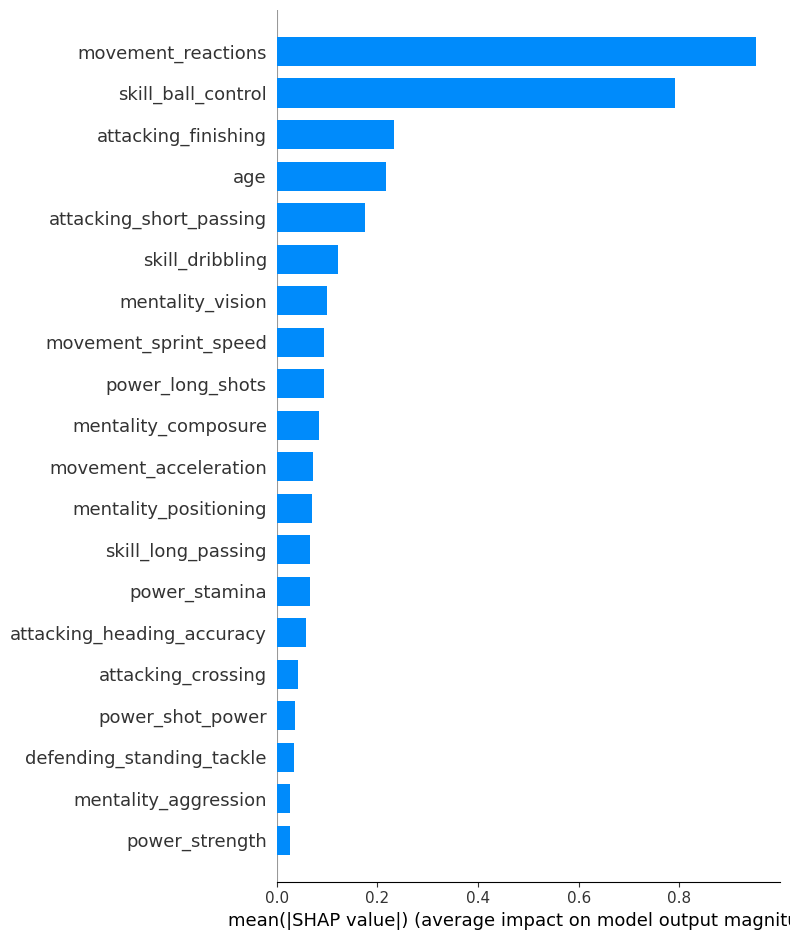

In [12]:
# Compute SHAP values
messi = df[df["short_name"].str.contains("Messi")][X.columns]

explainer = shap.TreeExplainer(model, messi) # Use the TreeExplainer algorithm with background distribution
shap_values = explainer.shap_values(X_test) # Get shap values
shap_values_exp = explainer(X_test) # Get explainer for X_test

shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

> I chose SHAP because it quantifies how much does a feature contribute to the difference between the actual prediction and the baseline value derived from the background dataset, so it appeared as a good option to evaluate the impact of each feature on the prediction. 

> In this case the feature that affects the "Messi" output the most is "movement_reaction". In this case low values of this feature notably decrease the value of Messi. 

---
Ex 4. Explain how perturbating the `height_cm` variable affect the value of Cristiano Ronaldo

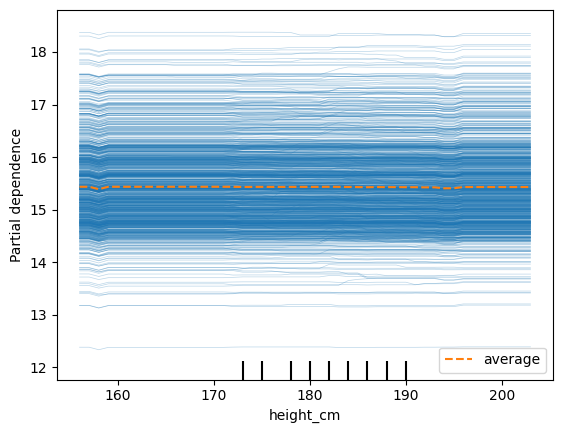

In [13]:
# Use default parameters for 1D Main Effect ALE Plot
cristiano = df[df["short_name"].str.contains("Ronaldo")][X.columns]
PartialDependenceDisplay.from_estimator(model, X, ["height_cm"], kind='both')

> I used PDP to see how the output varies by moving the height_cm feature accross all posible values. The value of Cristiano Ronaldo appears to be constant for all posible heights, which might indicate that the prediction does not depend on the height.

---
Ex 5. Explain the average effect of the `age` variable on the model predictions. Does it differ greatly along the samples in the dataset? Which should be more affected by perturbating this variable, the goalkeepers or the strikers?

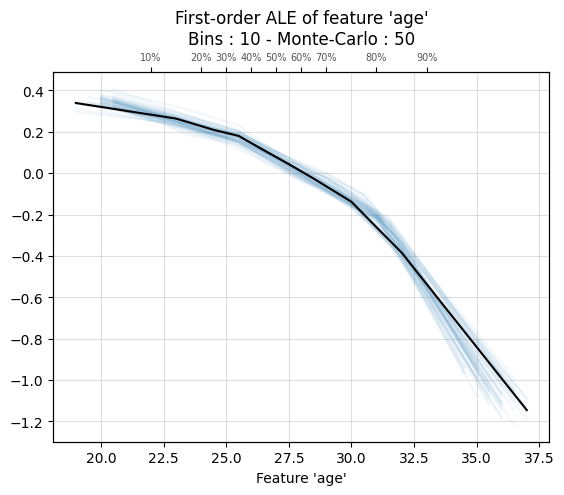

<Axes: title={'center': "First-order ALE of feature 'age'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'age'">

In [14]:
# Use default parameters for 1D Main Effect ALE Plot
ale_plot(model, X_train, 'age', monte_carlo=True)


C:\Users\User\AppData\Local\Temp\ipykernel_17764\1289327562.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['position_group'] = df_filtered.apply(classify_player, axis=1)


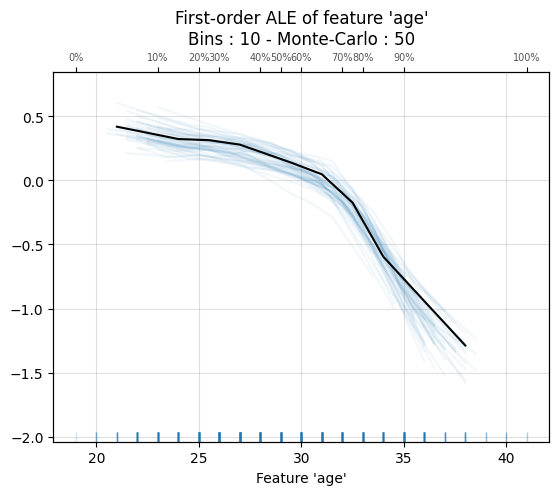

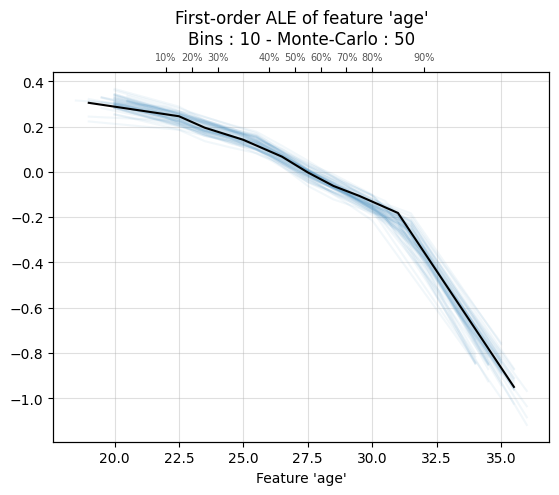

<Axes: title={'center': "First-order ALE of feature 'age'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'age'">

In [15]:
# Divido los jugadores entre strikers, defenders y goalkeepers.
goalkeeping_cols = ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
attacking_cols = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys']
defending_cols = ['defending_marking', 'defending_standing_tackle','defending_sliding_tackle']


df['attacking_mean'] = df[attacking_cols].mean(axis=1)
df['goalkeeping_mean'] = df[goalkeeping_cols].mean(axis=1)
df['defending_mean'] = df[defending_cols].mean(axis=1)

# Filtrar jugadores relevantes
df_filtered = df[(df['attacking_mean'] > df['defending_mean']) | (df['goalkeeping_mean'] > df['defending_mean'])]

# Asignar posición
def classify_player(row):
    if row['goalkeeping_mean'] > row['attacking_mean']:
        return 'goalkeeper'
    elif row['attacking_mean'] > row['goalkeeping_mean']:
        return 'striker'
    else:
        return 'other'

df_filtered['position_group'] = df_filtered.apply(classify_player, axis=1)

X_goalkeepers = df_filtered[df_filtered['position_group'] == 'goalkeeper'][X.columns]
X_strikers = df_filtered[df_filtered['position_group'] == 'striker'][X.columns]


ale_plot(model, X_goalkeepers, 'age', monte_carlo=True)
ale_plot(model, X_strikers, 'age', monte_carlo=True)

> I've used the ALE-plot because it computes the local effects that moving a variable through a window has. I have used ALE-plot instead of PDP to avoid generating imposible combinations of the variables. 

> The value of age does vary across the dataset, but most of the players are between 23 and 28 years old. It looks like the value of the player decreases as the age increases. The decrease is more subtle up to 30 years old, at this point, the decrease in value is more notable.

> To determine if the age feature affects more goalkeepers or strikers, I ploted the ALE-plot for both groups of players. It appears that the value for the age of goalkeepers affects the value more, as the range of variation for the output is greater for goalkeepers than strikers.

---
Ex 6. Explain the prediction made for Hazard using a local surrogate model (Lime)

In [16]:
# Define kernel_width
kernel_width = 3

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="regression", feature_names=X_train.columns, kernel_width=kernel_width)
# Choose a sample for explanation

hazard = df[df["short_name"].str.contains("Hazard")][X.columns].values[0]

# Explain the prediction using LIME
exp = explainer.explain_instance(hazard, model.predict)

# Show the explanation
exp.show_in_notebook(show_table=True)

> The resulting explanation appears to reveal that the feature that affects the most to the Hazard value prediction is movement_reaction. Particularly, a high value of movement_reaction increases the output of the model. For the rest of the features, they appear to increase the predicted value (less than the movement_reaction) except for the (apparently low) value of the defending_stading_tackle, which decreases the predicted output.
